# Chest X ray problem

Binary classification problem, we are asked to classify chest X rays from patients and tell which are sick and which are healty.

The dataset is deposited [here](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia).

For a "heavy guns" solution for this problem (with data augmentation, learning rate decay, memory optimization and other neat advanced stuff) see [here](https://www.kaggle.com/amyjang/tensorflow-pneumonia-classification-on-x-rays)

# Config

These constants are given for the exercise.

In [1]:
#where the data are stored
data_url = 'http://www.jackdellequerce.com/data/reduced_chest_xray.zip'

#where to place the data
download_target_imgs = '/content/data/'
base_dir = download_target_imgs + 'reduced_chest_xray/'

#Keras constants
BATCH_SIZE = 20
IMAGE_SIZE = [128, 128]
IMAGE_SHAPE = (IMAGE_SIZE[0], IMAGE_SIZE[1] , 3)
EPOCHS = 10

# Data setup

The following code ensures that the images are present in `base_dir` folder. If the data is not there it is downloaded and unpacked.

In [2]:
import glob     #for checking dir content
import os       #for dir creation
import requests #for data download
import zipfile  #for unpacking zipped files

#these two lists should contain the full paths of all train and test images
train_filenames = glob.glob(base_dir + 'train/*/*')
validation_filenames   = glob.glob(base_dir + 'test/*/*')

#let's check that we actually have the data
if len(train_filenames) == 0 or len(validation_filenames) == 0:
  #either the data was never downloaded or something bad happened
  #in any case, we donwload and unzip everything

  #room for data
  os.makedirs(download_target_imgs, exist_ok=True)

  #downloading
  r = requests.get(data_url)
  open(download_target_imgs + 'local_archive.zip', 'wb').write(r.content)

  #unpacking
  z = zipfile.ZipFile(download_target_imgs + 'local_archive.zip')
  z.extractall(path = download_target_imgs)

  #at this point data is there, we are ready to get the list of files
  train_filenames = glob.glob(base_dir + 'train/*/*')
  validation_filenames   = glob.glob(base_dir + 'test/*/*')

#whatever the original case, at this point we have the files
print('Available images for train: ' + str(len(train_filenames)))
print('Available images for validation: ' + str(len(validation_filenames)))

Available images for train: 300
Available images for validation: 100


# Data loading - ImageDataGenerator

We are going to use [ImageDataGenerator](https://keras.io/api/preprocessing/image/#imagedatagenerator-class) for loading the images from the local memory.

`ImageDataGenerator` class is defined in `keras.preprocessing.image` submodule and can be used for data augmentation and general data handling. 

When working with images it is important to rescale them in from the 0-255 range to 0-1, as explained in details [here](https://github.com/Arsey/keras-transfer-learning-for-oxford102/issues/1
).

**ASSIGNMENT**: In the next snippet you need to import `ImageDataGenerator` and then declare two objects named `train_datagen` and `validation_datagen`. Both need a rescaling factor or 1.0/255<br>
The ".0" part is important so python will do a floating point division and not an integer division, in fact:

- 1.0/255 → 0,003921569
- 1/255 → 0

**OPTIONAL ASSIGNMENT**: do some data augmentation telling `train_datagen` to do horizontal flips. Important: never do data augmentation on validation set. Can you guess what the consequences would be?

In [3]:
### YOUR CODE HERE ###
#import ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator

#declare two objects
train_datagen      = ImageDataGenerator(rescale=1./255, horizontal_flip=True)
validation_datagen = ImageDataGenerator(rescale=1./255)
######################

In so far you have declared the `ImageDataGenerator` objects, but you have not linked them to the actual files. It's now time to do so.

**ASSIGNMENT** use the [flow_from_directory()](https://keras.io/api/preprocessing/image/#flowfromdirectory-method) method to link the `validation_datagen` object to its folder.

**NOTE**: parameter `batch_size` on train dataset influences the amount of memory required. Usually the bigger the better, but the system can easily become overloaded. On validation dataset it is **important** to give a number that exactly divides the number of available samples, otherwise some samples will never be used. When in doubt put it to 1 (only for validation).  

In [4]:
#let's put the dirs in a handy place
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'test')

#linking the actual data
train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        # We have two classes, we'll work in binary mode
        class_mode='binary')

### YOUR CODE HERE ###
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE, 
        class_mode='binary')
######################

Found 300 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


# Architecture - Define

It's now time to define an architecture. You'll use the usual [Sequential model](https://keras.io/guides/sequential_model/).

**ASSIGNMENT**: Declare a model with the following layers:

1. [Conv2D layer](https://keras.io/api/layers/convolution_layers/convolution2d/), 32 nodes, 3x3 kernel, "same" padding, "relu" activation
2. [MaxPooling2D layer](https://keras.io/api/layers/pooling_layers/max_pooling2d/), 2x2 pool size
3. another Conv2D layer, this time 64 nodes, everything else same as above
4. another MaxPooling2D, same as above
5. [Flatten layer](https://keras.io/api/layers/reshaping_layers/flatten/)
6. [Dense layer](https://keras.io/api/layers/core_layers/dense/), used as output, "sigmoid" activation function. Can you guess the number of nodes?

The first layer is the input layer and requires also an `input_shape`, which you find in the `IMAGE_SHAPE` constant you declared above.

**OPTIONAL ASSIGNMENT** put a Dropout layer after the first MaxPooling2D with a rate of 0.2. Do you need to change something else in the code?


In [6]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

#let's declare an empty model
model = Sequential()

### YOUR CODE HERE ###
from keras.layers import Dropout
model.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu", input_shape=IMAGE_SHAPE))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
######################

# Architecture - Take a look

You have defined the architecture, it's time to take a look at your work. Keras offers two options: 

* the [.summary()](https://keras.io/api/models/model/#summary-method) method built-in your model object
* [plot_model()](https://keras.io/api/utils/model_plotting_utils/#plotmodel-function) function from `keras.utils.vis_utils` package.

**ASSIGNMENT** invoke either `.build()` (easy) or `plot_model()` (more complicated), take a look inside your model and verify that everything is as expected in terms of number of layers, output size and so forth.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 65536)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 6

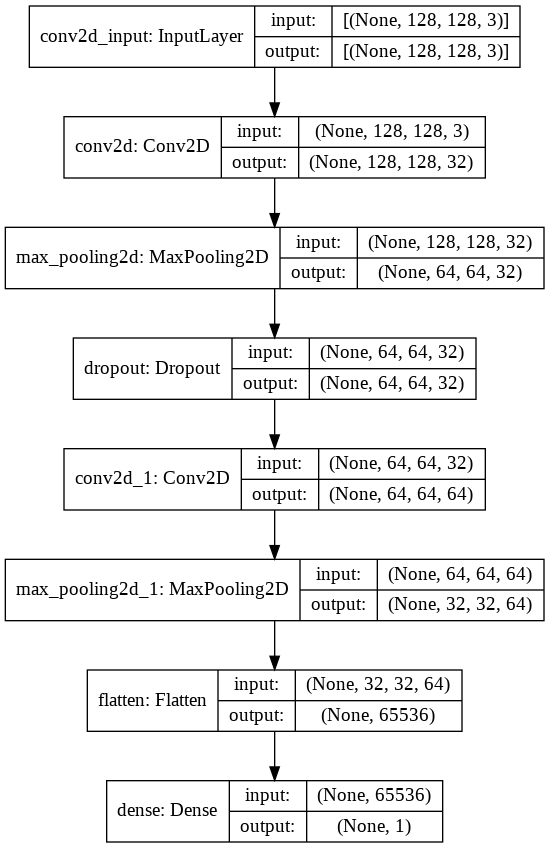

In [7]:
### YOUR CODE HERE ###
#option 1
model.summary()

#option 2
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
######################

# Architecture - Compile

So far you have defined the topology of your network, it's now time to specify how you are going to measure its performance.

**ASSIGNMENT** invoke the [.compile()](https://keras.io/api/models/model_training_apis/#compile-method)  method for your model, specifying the [loss function](https://keras.io/api/losses/) (we are doing binary classification, so 'binary_crossentropy' is the standard choice)

**OPTIONAL ASSIGNMENT 1**: ask keras to keep track of an extra metric, 'accuracy'. Keep in mind that `.compile()` expects a list of strings when specifying metrics, even if only one element is present.

**OPTIONAL ASSIGNMENT 2**: default optimizer is [RMSprop](https://keras.io/api/optimizers/rmsprop/), with a default learning rate of 0.001. Declare the optimizer so that the used learning rate is 0.00002. (Tip: you'll need to import RMSprop from tensorflow...) 

In [ ]:
### YOUR CODE HERE ###
from tensorflow.keras.optimizers import RMSprop
# Model compile
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=2e-5),
              metrics=['accuracy'])
######################


# Train

It's finally time to train your model using the [.fit()](https://keras.io/api/models/model_training_apis/#fit-method) method.

**ASSIGNMENT**: train your model speifying that:

* your train data (argument `x`) is in `train_generator`
* your validation data (argument `validation_data`) is in `validation_generator`
* the desider number of epochs (argument `epochs`) is in the declared constant `EPOCHS`
* `verbose` level = 2 so that we can take a look at what's happening

The returned object should go in a new variable called `train_log`

In [ ]:
### YOUR CODE HERE ###
train_log = model.fit(
      x=train_generator,
      epochs=EPOCHS,
      validation_data=validation_generator,
      verbose=2)
######################

Epoch 1/10
15/15 - 14s - loss: 0.6769 - accuracy: 0.5933 - val_loss: 0.6770 - val_accuracy: 0.7200
Epoch 2/10
15/15 - 12s - loss: 0.6630 - accuracy: 0.6700 - val_loss: 0.6678 - val_accuracy: 0.7000
Epoch 3/10
15/15 - 12s - loss: 0.6505 - accuracy: 0.6567 - val_loss: 0.6646 - val_accuracy: 0.5700
Epoch 4/10
15/15 - 12s - loss: 0.6334 - accuracy: 0.7900 - val_loss: 0.6523 - val_accuracy: 0.8400
Epoch 5/10
15/15 - 12s - loss: 0.6188 - accuracy: 0.8200 - val_loss: 0.6425 - val_accuracy: 0.8800
Epoch 6/10
15/15 - 12s - loss: 0.5994 - accuracy: 0.8233 - val_loss: 0.6327 - val_accuracy: 0.7300
Epoch 7/10
15/15 - 12s - loss: 0.5931 - accuracy: 0.8067 - val_loss: 0.6239 - val_accuracy: 0.8900
Epoch 8/10
15/15 - 12s - loss: 0.5738 - accuracy: 0.8533 - val_loss: 0.6138 - val_accuracy: 0.9000
Epoch 9/10
15/15 - 12s - loss: 0.5635 - accuracy: 0.8467 - val_loss: 0.6108 - val_accuracy: 0.7600
Epoch 10/10
15/15 - 12s - loss: 0.5446 - accuracy: 0.8433 - val_loss: 0.5954 - val_accuracy: 0.8900


# Support function for plotting metrics

The following function is a small utility that allows for plotting loss and all the metrics returned by a `.fit()` call. Just execute the snippet so that the function is declared. Or, if you are curious, take a look at the code :)

In [ ]:
import matplotlib.pyplot as plt

def plot_loss_history(h, title):
  for metric in h.history.keys():
    #ignoring metrics on validation set, which are implied when
    #plotting on training set
    if metric.startswith('val_'):
      continue
    
    #if we get here we found a metric on the training set,
    #let's plot it
    plt.plot(h.history[metric], label = "Train set")
    plt.plot(h.history["val_" + metric], label = "Validation set")
    plt.xlabel('Epochs')
    plt.title(title + ' - ' + metric)
    plt.legend()
    plt.show()

# Plotting your model performances

As a final step, plot loss (and metrics, if present) of your training.

**ASSIGNMENT**: use the `plot_loss_history()` you just declared to plot the evolution of your training. What consideration can you do?

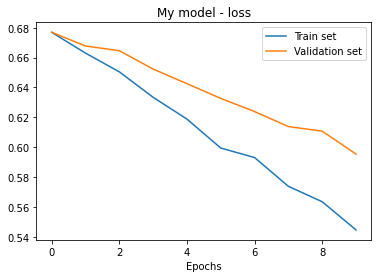

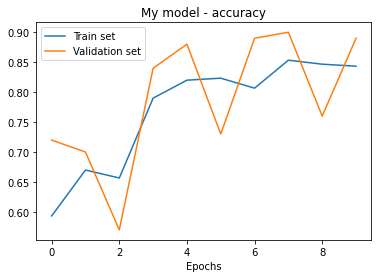

In [ ]:
### YOUR CODE HERE ###
plot_loss_history(train_log, 'My model')
######################